# ***Applying Transfer learning and using the embedded vectors from Doc2Vec to train a Pytorch Neural Network :***

In [203]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from matplotlib import pyplot as plt
import seaborn as sns

Now that we got our embedded vectors from all the reviews using doc2vec and saved them in a csv file, we first start by importing the embeddings and then we will split these vectors into train set , validation set and test set and then train different NN and pick up the one that performs the best on the validation set 

# ***Getting the arrays of the reviews and the target sentiments :***

In [153]:
data_new=pd.read_csv('./data/doc2vec_dataset.csv',sep='\t')

In [154]:
def str_to_float(row):
    rev=row['embedded review']
    rev=re.sub('[\n]', '', rev).strip('[]').split()
    return(np.array(rev,dtype=str).astype(np.float))

In [155]:
data_new['array']=data_new.progress_apply(str_to_float,axis=1)

100%|██████████| 50000/50000 [00:06<00:00, 7607.79it/s]


In [156]:
X=np.array(data_new['array'].to_list(),dtype='float64')
Y=data_new['sentiment'].to_numpy()

# ***Splitting the data and Standardizing using X_train :***

In [157]:
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.33,random_state=40)
X_test,X_val,Y_test,Y_val=train_test_split(X_val,Y_val,test_size=0.5,random_state=40)


In [158]:
std=StandardScaler().fit(X=X_train)
std

StandardScaler()

In [159]:
X_train_std,X_val_std,X_test_std=std.transform(X_train),std.transform(X_val),std.transform(X_test)
print(f'mean of training data after standardizing : {X_train_std.mean():.5f}')
print('-'*50)
print(f'mean of testing data after standardizing : {X_test_std.mean():.5f}')

mean of training data after standardizing : -0.00000
--------------------------------------------------
mean of testing data after standardizing : -0.00007


# ***Training our NN on classifying the embeddings of the reviews :***

In [184]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1=torch.nn.Linear(self.input_size,self.hidden_size)
            self.relu=torch.nn.ReLU()
            self.drop=torch.nn.Dropout(p=0.3)
            self.fc2 = torch.nn.Linear(self.hidden_size, 2)
            self.sigmoid = torch.nn.Sigmoid()        
        def forward(self, x):
            fc=self.fc1(x)
            relu=self.relu(fc)
            drop=self.drop(relu)
            output = self.fc2(drop)
            output = self.sigmoid(output)
            return output

In [161]:
X_train_std,Y_train=torch.FloatTensor(X_train_std).cuda(),torch.FloatTensor(Y_train).long().cuda()
X_val_std,Y_val=torch.FloatTensor(X_val_std).cuda(),torch.FloatTensor(Y_val).long().cuda()
X_test_std,Y_test=torch.FloatTensor(X_test_std).cuda(),torch.FloatTensor(Y_test).long().cuda()

In [185]:
model = Feedforward(300, 500)
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [186]:
model.cuda()

Feedforward(
  (fc1): Linear(in_features=300, out_features=500, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [187]:
model.eval()
Y_pred = model(X_val_std)
before_train = criterion(Y_pred, Y_val)
print(f'Evaluation loss before training   :   {before_train.item():.3f}')

Evaluation loss before training   :   0.691


In [188]:
model.train()
epoch = 10000
batch_size=1000
for epoch in tqdm(range(epoch)):
    loss_list=[]
    for i in range(0,len(X_train_std),batch_size):
        X_batch=X_train_std[i:i+batch_size] 
        Y_batch=Y_train[i:i+batch_size]    
        optimizer.zero_grad()    # Forward pass
        y_pred = model(X_batch)    # Compute Loss
        loss=criterion(y_pred, Y_batch)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    
    if epoch%3000==0:
        print('-'*50)
        print('Epoch {}: train loss: {:.3f}\n'.format(epoch, np.mean(loss_list)))    # Backward pass
        

  0%|          | 4/10000 [00:00<05:02, 33.03it/s]

--------------------------------------------------
Epoch 0: train loss: 0.690



 30%|███       | 3006/10000 [01:14<02:49, 41.17it/s]

--------------------------------------------------
Epoch 3000: train loss: 0.412



 60%|██████    | 6007/10000 [02:29<01:37, 40.96it/s]

--------------------------------------------------
Epoch 6000: train loss: 0.371



 90%|█████████ | 9009/10000 [03:42<00:23, 41.52it/s]

--------------------------------------------------
Epoch 9000: train loss: 0.354



100%|██████████| 10000/10000 [04:06<00:00, 40.54it/s]


In [189]:
model.eval()
Y_pred = model(X_val_std)
after_train = criterion(Y_pred, Y_val)
print(f'Evaluation loss after training   :   {after_train.item():.3f}')

Evaluation loss after training   :   0.508


In [196]:
model.eval()
Y_pred = model(X_test_std)
targets_pred=torch.argmax(Y_pred,dim=1).cpu().numpy()
Y_test=Y_test.cpu().numpy()
test_acc=(targets_pred==Y_test).mean()
print(f'Final Test Accuracy   :   {test_acc:.3f}')

Final Test Accuracy   :   0.800


In [197]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(Y_test, targets_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.81      0.79      0.80      4222
    positive       0.79      0.81      0.80      4028

    accuracy                           0.80      8250
   macro avg       0.80      0.80      0.80      8250
weighted avg       0.80      0.80      0.80      8250



NameError: name 'sns' is not defined

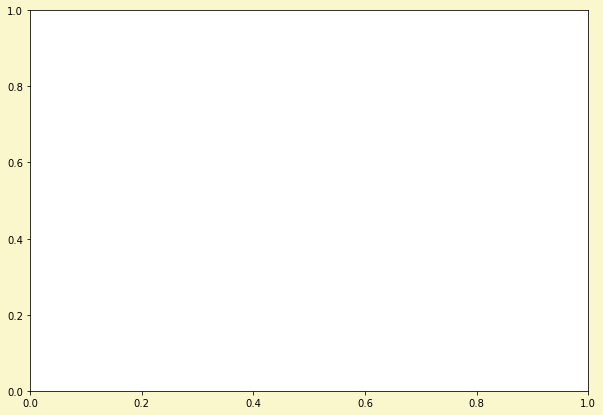

In [202]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="flare",linecolor="red",vmin=50,vmax=1400)
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize = (10, 7),facecolor='#FAF7CC')
cm = confusion_matrix(Y_test, targets_pred)
df_cm = pd.DataFrame(cm, index=['negative','positive'], columns=['negative','positive'])
show_confusion_matrix(df_cm)